In [80]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras
import sys
import logging
sys.path.insert(0, '../')

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.11.0


In [83]:
logging.basicConfig(filename='results.log')
handler = logging.FileHandler('results.log')
handler.setLevel(logging.INFO)
logger.addHandler(handler)

In [84]:
logging.info('Hey, it is good!')

### Import the MNIST dataset/ Preprocess the data

In [2]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [25]:
x_train = x_train/255
x_test = x_test/255

In [3]:
num_classes = 10

In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Train and test the network on MNIST

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

In [6]:
from adv_util import create_fully_connected

In [70]:
def flatten_mnist(x):
    n, img_rows, img_cols = x.shape
    D = img_rows * img_cols
    x_flattened = x.reshape(n, D)
    return x_flattened, (D, )

In [87]:
def evaluate_on_both(model, x_test_flat, y_test, corrupt_func):
    loss_benign, acc_benign = model.evaluate(x_test_flat, y_test, verbose=False)
    x_test_corrupt = corrupt_data(x_test, x_test.shape[0], corrupt_func)
    x_test_corrupt_flat, _ = flatten_mnist(x_test_corrupt)
    loss_corrupt, acc_corrupt = model.evaluate(x_test_corrupt_flat, y_test, verbose=False)
    return (loss_benign, acc_benign, loss_corrupt, acc_corrupt)                               

In [90]:
def compile_train_test(x_train, y_train, x_test, y_test, reg, corrupt_func = None):
    
    #Config
    frac = 0.4
    num_classes = 10
    
    x_train_flat, input_shape = flatten_mnist(x_train)
    x_test_flat, _ = flatten_mnist(x_test)
    
    print("Reg value:" + str(reg))
    
    #Fit regular data
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, reg = reg)
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train_flat, y_train, batch_size=128, epochs=15, verbose=True, validation_split=.1)
    loss_benign, acc_benign, loss_corrupt, acc_corrupt = evaluate_on_both(model, x_test_flat, y_test, corrupt_func)
    
   
    #Fit corrupted data
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, reg = reg)
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    x_train_corrupt = corrupt_data(x_train, int(np.round(frac*x_train.shape[0])), corrupt_func)
    x_train_corrupt_flat, _ = flatten_mnist(x_train_corrupt)
    model.fit(x_train_corrupt_flat, y_train, batch_size=128, epochs=15, verbose=True, validation_split=.1)
    
    loss_benign_poison, acc_benign_poison, loss_corrupt_poison, acc_corrupt_poison = evaluate_on_both(model, x_test_flat, y_test, corrupt_func)

    #Logging observations
    #logging.info('Reg: %s Corrupt: %s Frac_corrupt: %s Loss_regular: %s Accuracy_regular %s Loss_corrupt %s Accuracy_corrupt %s '
                    #% (reg, str(corrupt_func), frac, loss_regular, accuracy_regular, loss_corrupt, accuracy_corrupt))
    
    
    #Stuff to return
    x_loss = loss_benign_poison - loss_benign
    x_acc = acc_benign_poison - acc_benign
    y_loss = loss_corrupt - loss_benign
    y_acc = acc_corrupt - acc_benign
    
    logging.info('Reg: %s Corruption: %s Frac_corrupt: %s Stability_loss %s Stability_acc %s Gen_loss %s Gen_acc %s'
                    % (reg, str(corrupt_func), frac, x_loss, x_acc, y_loss, y_acc))
    return x_loss, x_acc, y_loss, y_acc
    #return loss_regular, accuracy_regular, loss_corrupt, accuracy_corrupt

# Blurring

In [103]:
from mnist_corruption import gaussian_blurring, corrupt_data, random_perturbation, random_blackout_whiteout

In [104]:
x_small = x_train[0:3]

x_corrupted_small = random_blackout_whiteout(x_small)
x_corrupted_reshaped = x_corrupted_small.reshape((x_corrupted_small.shape[0], 784))

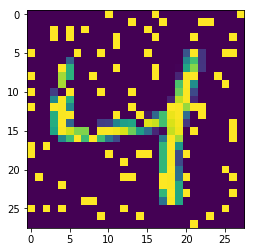

In [105]:
plt.imshow(x_corrupted_small[2])

## Stability and Generalization

In [ ]:
from adv_util import create_fully_connected

In [106]:
reg_array = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
diff_loss_lst = []
diff_acc_lst = []
acc_corrupt_lst = []
loss_corrupt_lst =[]

for reg in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    diff_loss, diff_acc, loss_test_corrupt, accuracy_test_corrupt = compile_train_test(x_train, y_train, x_test, y_test, reg, random_blackout_whiteout)
    diff_loss_lst.append(diff_loss)
    diff_acc_lst.append(diff_acc)
    acc_corrupt_lst.append(accuracy_test_corrupt)
    loss_corrupt_lst.append(loss_test_corrupt)


Reg value:1e-05
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 6s 106us/step - loss: 2.3187 - acc: 0.1475 - val_loss: 2.2743 - val_acc: 0.2205
Epoch 2/15
54000/54000 [==============================] - 2s 36us/step - loss: 2.2601 - acc: 0.2139 - val_loss: 2.2411 - val_acc: 0.2730
Epoch 3/15
54000/54000 [==============================] - 2s 42us/step - loss: 2.2253 - acc: 0.2797 - val_loss: 2.2003 - val_acc: 0.3597
Epoch 4/15
54000/54000 [==============================] - 2s 42us/step - loss: 2.1799 - acc: 0.3400 - val_loss: 2.1452 - val_acc: 0.3823
Epoch 5/15
54000/54000 [==============================] - 2s 40us/step - loss: 2.1191 - acc: 0.3801 - val_loss: 2.0725 - val_acc: 0.4402
Epoch 6/15
54000/54000 [==============================] - 2s 44us/step - loss: 2.0399 - acc: 0.4361 - val_loss: 1.9808 - val_acc: 0.4777
Epoch 7/15
54000/54000 [==============================] - 2s 41us/step - loss: 1.9445 - acc: 0.4765 - val_loss: 

Epoch 14/15
54000/54000 [==============================] - 2s 43us/step - loss: 1.4139 - acc: 0.6641 - val_loss: 1.3369 - val_acc: 0.6997
Epoch 15/15
54000/54000 [==============================] - 2s 43us/step - loss: 1.3308 - acc: 0.6810 - val_loss: 1.2536 - val_acc: 0.7233
Reg value:0.001
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 7s 132us/step - loss: 2.4256 - acc: 0.1459 - val_loss: 2.3832 - val_acc: 0.2612
Epoch 2/15
54000/54000 [==============================] - 2s 38us/step - loss: 2.3710 - acc: 0.2123 - val_loss: 2.3559 - val_acc: 0.2808
Epoch 3/15
54000/54000 [==============================] - 2s 39us/step - loss: 2.3427 - acc: 0.2978 - val_loss: 2.3243 - val_acc: 0.4162
Epoch 4/15
54000/54000 [==============================] - 2s 38us/step - loss: 2.3090 - acc: 0.3987 - val_loss: 2.2859 - val_acc: 0.4723
Epoch 5/15
54000/54000 [==============================] - 2s 38us/step - loss: 2.2666 - acc: 0.4660 - val_loss

Epoch 12/15
54000/54000 [==============================] - 2s 43us/step - loss: 2.4605 - acc: 0.2477 - val_loss: 2.4485 - val_acc: 0.2302
Epoch 13/15
54000/54000 [==============================] - 3s 48us/step - loss: 2.4369 - acc: 0.2464 - val_loss: 2.4268 - val_acc: 0.2455
Epoch 14/15
54000/54000 [==============================] - 2s 37us/step - loss: 2.4166 - acc: 0.2387 - val_loss: 2.4083 - val_acc: 0.2432
Epoch 15/15
54000/54000 [==============================] - 2s 38us/step - loss: 2.3991 - acc: 0.2433 - val_loss: 2.3919 - val_acc: 0.2693
Reg value:0.1
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 7s 126us/step - loss: 7.6425 - acc: 0.1031 - val_loss: 4.3310 - val_acc: 0.1050
Epoch 2/15
54000/54000 [==============================] - 2s 41us/step - loss: 3.2836 - acc: 0.1132 - val_loss: 2.6776 - val_acc: 0.1050
Epoch 3/15
54000/54000 [==============================] - 2s 42us/step - loss: 2.4831 - acc: 0.1132 - val_loss

Epoch 10/15
54000/54000 [==============================] - 2s 42us/step - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 11/15
54000/54000 [==============================] - 2s 41us/step - loss: 2.3012 - acc: 0.1132 - val_loss: 2.3020 - val_acc: 0.1050
Epoch 12/15
54000/54000 [==============================] - 2s 39us/step - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 13/15
54000/54000 [==============================] - 2s 44us/step - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 14/15
54000/54000 [==============================] - 2s 46us/step - loss: 2.3012 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 15/15
54000/54000 [==============================] - 2s 44us/step - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Reg value:10
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 7s 128us/step - loss: 9.5701 - acc: 0.1116 - val_los

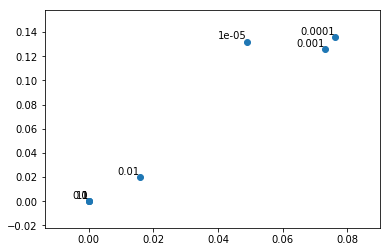

In [107]:
diff_loss_lst = [np.abs(x) for x in diff_loss_lst]
loss_corrupt_lst = [np.abs(x) for x in loss_corrupt_lst]

plt.scatter(diff_loss_lst, loss_corrupt_lst)
plt.xlabel('Poisoning Loss - Test loss')
plt.ylabel('Corruption Test Loss - Test Loss')

for k in range(len(reg_array)):
    reg_val = reg_array[k]
    x = diff_loss_lst[k]
    y = loss_corrupt_lst[k]
    plt.annotate(reg_val, xy=(x, y), xytext=(-0.5, 0.5), textcoords='offset points', ha='right', va='bottom')
plt.savefig('random_blackwhite_loss.png')

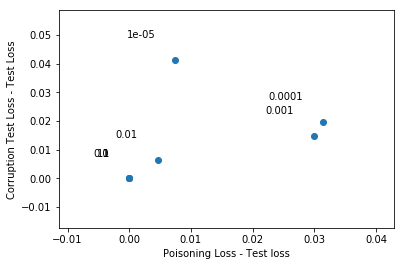

In [109]:
diff_acc_lst = [np.abs(x) for x in diff_acc_lst]
acc_corrupt_lst = [np.abs(x) for x in acc_corrupt_lst]

plt.scatter(diff_acc_lst, acc_corrupt_lst)
plt.xlabel('Poisoning Loss - Test loss')
plt.ylabel('Corruption Test Loss - Test Loss')
for k in range(len(reg_array)):
    reg_val = reg_array[k]
    x = diff_acc_lst[k]
    y = acc_corrupt_lst[k]
    plt.annotate(reg_val, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')
plt.savefig('random_blackwhite_acc.png')